<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/lesson_5/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [50]:
#df = pd.read_csv("churn_data.csv")

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [51]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [52]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [53]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [54]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [55]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [57]:
from sklearn.preprocessing import StandardScaler

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [58]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [59]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

#**LogisticRegression**

In [60]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [61]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [62]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


#**RandomForestClassifier**

In [64]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [65]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [66]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [67]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


#**GradientBoostingClassifier**

In [75]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [76]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [77]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [78]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Лучше всех справился GradientBoostingClassifier

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:
* precision (точность) - способность алгоритма отличить один класс от другого с максимальной точностью.
* recall (полнота) - способность алгоритма обнаружить наличие долю + объектов из всех объктов + класса
Если точность равна 1 и полнота также равна 1, оценка F1 также будет равна 1. Это самая идеальная ситуация.
Количество ложноположительных результатов увеличивается, а количество ложноотрицательных уменьшается. В результате точность снижается, а полнота увеличивается.Yвеличивая точность, мы уменьшаем полноту.
Cуществует обратная зависимость между точностью и полнотой, когда можно увеличить одно за счет уменьшения другого.

Отрисуем матрицу ошибок

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


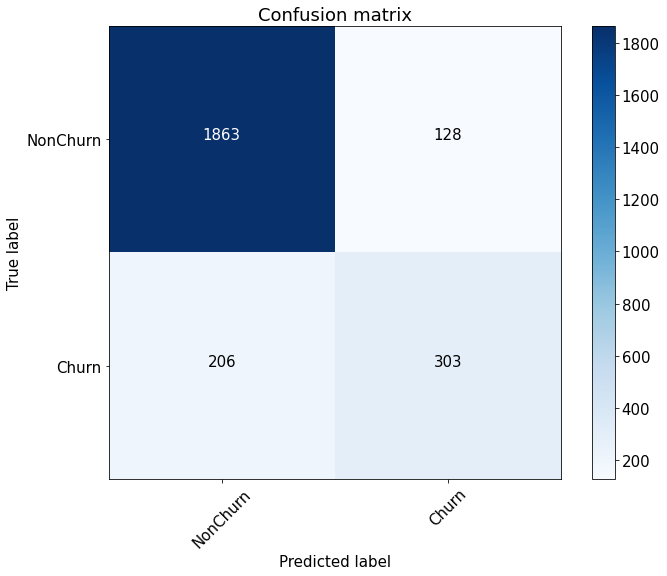

In [81]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [ ]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [ ]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Обучаем модель уже сновыми параметрами

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

In [ ]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

### Кейс 2. Отток пользователей в онлайн-игре

https://mlbootcamp.ru/ru/round/10/sandbox/

В этой задаче необходимо научиться предсказывать, остается ли участник в он-лайн игре или уходит из нее. Уходом считается отсутствие его в игре в течение недели.

 

Всего используется 12 признаков, вычисленных за 2 предыдущие недели:

- maxPlayerLevel - максимальный уровень игры, который прошел игрок
- numberOfAttemptedLevels - количество уровней, которые попытался пройти игрок
- attemptsOnTheHighestLevel - число попыток, сделанных на самом высоком уровне
- totalNumOfAttempts - общее число попыток
- averageNumOfTurnsPerCompletedLevel - среднее количество ходов, выполненных на успешно пройденных уровнях
- doReturnOnLowerLevels - делал ли игрок возвраты к игре на уже пройденных уровнях
- numberOfBoostersUsed - количество использованных бустеров
- fractionOfUsefullBoosters - количество бустеров, использованных во время успешных попыток (игрок прошел уровнь)
- totalScore - общее количество набранных очков
- totalBonusScore - общее количество набранных бонусных очков
- totalStarsCount - общее количество набранных звезд
- numberOfDaysActuallyPlayed - количество дней, когда пользователь играл в игру

Все предоставленные для задачи данные разбиты на две части: обучающую (x_train.csv и y_train.csv) и тестовую (x_test.csv). Каждая строка файлов x_train.csv и x_test.csv соответствует одному пользователю. Данные в строке разделены точкой с запятой. Первая строка содержит имена признаков. Файл y_train.csv содержит значения 1 или 0 в зависимости от того, остался пользователь в игре или вышел из нее соответственно.

Как обучающая (x_train.csv и y_train.csv), так и тестовая (x_test.csv) выборки содержат информацию о 25289 пользователях.

Решение победителя https://habr.com/ru/post/324916/ (немного адаптированное)

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import random

random.seed(666)
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
def loss_func(y_true, y_pred):
    return log_loss(y_true, y_pred)


all_train = pd.read_csv('x_train.csv', sep=';')
all_target = pd.read_csv('y_train.csv', sep=';', names=['TARGET'])
all_train['TARGET'] = all_target['TARGET']

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(all_train, all_train['TARGET'], random_state=0)

In [ ]:
cols_to_drop = ['ID', 'TARGET']
cols = list(set(all_train.columns) - set(cols_to_drop))
base_cols = cols

In [ ]:
# определи группы одинаковых строк
X_train['row_id'] = X_train[base_cols].apply(lambda row: '_'.join([str(i) for i in row]), axis=1)
X_test['row_id'] = X_test[base_cols].apply(lambda row: '_'.join([str(i) for i in row]), axis=1)

gb = X_train.groupby(['row_id'], as_index=False).size()
gb.name = 'size'
gb = gb.reset_index()
sizdata = gb[gb['size'] > 50].sort_values('size', ascending=False)

similar_data = X_train[X_train['row_id'].isin(sizdata['row_id'].values)]

In [ ]:
# генерируем признаки
def transform_data(data):
    for i1, col1 in enumerate(base_cols):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)

        for i2, col2 in enumerate(base_cols):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

            data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)

    return data


X_train_tr = transform_data(X_train)
X_test_tr = transform_data(X_test)

In [ ]:
cols = [col for col in X_train_tr.drop(['TARGET', 'row_id'], 1).columns]

In [ ]:
len(cols)

In [ ]:
# выборки для разных моделей
X_train_gb = X_train[cols].values

scaler_reg = MinMaxScaler((-1, 1))
scaler_reg.fit(np.vstack((X_train_tr[cols], X_test_tr[cols])))
X_train_reg = scaler_reg.transform(X_train_tr[cols])
X_test_reg = scaler_reg.transform(X_test_tr[cols])

In [ ]:
# ------------------------------------------------------------------
params = {
    'silent': 1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.01,
    'subsample': 0.4,
    'min_child_weight': 7,
    'n': 580,
    'verbose': 1
}

dtrain = xgb.DMatrix(X_train_tr[cols], label=y_train, missing=np.NaN)


bst1 = xgb.XGBClassifier(boosting_type='gbdt', **params)
bst1.fit(X_train_tr[cols], y_train)
# ------------------------------------------------------------------
params_est = {
    'n_estimators': 300,
    'loss': 'exponential',
    'learning_rate': 0.08,
    'subsample': 0.6910000000000001,
    'min_samples_leaf': 340,
    'max_features': 53,
    'random_state': 1,
    'verbose': 1
}
bst2 = GradientBoostingClassifier(**params_est)
bst2.fit(X_train_tr[cols], y_train)

In [ ]:
#обычная логистическая регрессия
bst3 = LogisticRegression()
bst3.fit(X_train_reg, y_train)

Посчитаем скоры

In [ ]:
t1 = bst1.predict_proba(X_test_tr[cols])[:, 1]
t2 = bst2.predict_proba(X_test_tr[cols].values)[:,1]
t3 = bst3.predict_proba(X_test_reg)[:,1]

Объединим все

In [ ]:
results = pd.DataFrame({'y_true': y_test,
              'XGB': t1,
              'GBM': t2,
              'LR': t3})
results['AVG_xgb_gbm_lr'] = results[['XGB', 'GBM', 'LR']].mean(axis=1)
results['AVG_xgb_lr'] = results[['XGB', 'LR']].mean(axis=1)
results

Посчитаем метрики

In [ ]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score(y_test, probs)))
    return thresholds[ix]

In [ ]:
xgb_th = get_metrics(results['XGB'])
gbm_th = get_metrics(results['GBM'])
lr_th = get_metrics(results['LR'])
blending_th = get_metrics(results['AVG_xgb_gbm_lr'])
blending2_th = get_metrics(results['AVG_xgb_lr'])

Ничего особенного блендинг нам не дает, но вполне возможно, что при большем количестве моделей результат может быть иным. 

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html
7. https://habr.com/ru/post/292312/
8. https://habr.com/ru/post/436236/
9. https://lifetimes.readthedocs.io/en/master/